# Model optimisation

Model optimised based on data from [Tsutsumi _et al._ 2011](https://doi.org/10.1038/nsmb.2125).

This notebook only shows the optimisation strategy, the actual optimised paramters used in the model can be found in ``params.py``.

## Setup

In [1]:
#setup workspace
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from scipy.integrate import solve_ivp
import  model_utils as mu
from scipy.optimize import curve_fit
import cma

In [2]:
#set up initial conditions
##initial concentrations (nM) as outlined in Tsutsumi et al.
pre_wt = 1
pre_sl = 1
wt_dcr = 0
sl_dcr = 0
wt_dcr_star = 0
sl_dcr_star = 0
dcr_wt = 5 #free Dicer in WT system
dcr_sl = 5 #free Dicer in SL system
wt = 0
sl = 0

init_values = [pre_wt, pre_sl, wt_dcr, sl_dcr, wt_dcr_star, sl_dcr_star, dcr_wt, dcr_sl, wt, sl]

##measured affinities for wt, sl pre-miRNAs (nM)
Kd_wt = 25.4
Kd_sl = 147.7

##initial theta (reaction rates) to be optimised:
ka_wt = 5
ka_sl = 5
kc_wt = .1
kc_sl = .1
kd = 5 

theta = np.log(np.array([ka_wt, ka_sl, kc_wt, kc_sl, kd, kd])) #log theta to prevent negative reaction rates in optimisation

#experimental data from figure 1, tsutsumi et al. to pass to optimiser
##extracted from graph
WT_data = np.array([0, 0.11144276160503169, 0.16566679779700877, 0.23905143587726366, 0.2954956726986665, 0.2946793863099961])
short_data = np.array([0, 0.0033684107002276975, 0.007599822974028003, 0.010019177812737812, 0.009603658536577298, 0.01242378048779691])
##simulation time and time steps
time = np.array([0, 5, 10, 20, 40, 60])
minutes = 60

### Functions

In [3]:
#model
def optim_model(t, init_values, ka1, ka2, kc1, kc2, kd1, kd2):
    """
    Model for optimising parameters for expanded model. Using short loop and wt maturing 
    miRNAs in separate Dicer pool.
    """   
    kb1 = ka2 * Kd_wt #Kd = kb / ka
    kb2 = ka2 * Kd_sl
    
    init_pMiR1, init_pMiR2, init_pMiR1_dcr, init_pMiR2_dcr, init_pMiR1_dcr_star, \
    init_pMiR2_dcr_star, init_dcr1, init_dcr2, init_miR1, init_miR2 = init_values
    
    pMiR1 = init_pMiR1_dcr * kb1 - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    pMiR1_dcr = init_pMiR1 * init_dcr1 * ka1 - init_pMiR1_dcr * (kb1 + kd)
    pMiR1_dcr_star = init_pMiR1 * init_dcr1 * kc1
    dcr1 = init_pMiR1_dcr * (kb1 + kd) - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    MiR1 = init_pMiR1_dcr * kd1
    
    pMiR2 = init_pMiR2_dcr * kb2 - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    pMiR2_dcr = init_pMiR2 * init_dcr2 * ka2 - init_pMiR2_dcr * (kb2 + kd)
    pMiR2_dcr_star = init_pMiR2 * init_dcr2 * kc2
    dcr2 = init_pMiR2_dcr * (kb2 + kd) - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    MiR2 = init_pMiR2_dcr * kd2

    
    return pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2
    

In [4]:
#calculate fraction diced
def frac_diced(theta):
    """
    Function to calculate the fraction of WT, short loop miRNAs diced
    """
    ka1, ka2, kc1, kc2, kd1, kd2 = np.exp(theta)
        
    sol = solve_ivp(optim_model, (0, int(minutes)), init_values, \
                    method = 'LSODA', args = (ka1, ka2, kc1, kc2, kd1, kd2))
    
    pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2 = sol.y
    
    diced1 = []
    diced2 = []
    
    for i in range(len(MiR1)):
        diced1.append(MiR1[i]/ pMiR1[0]) #1 pMiR = 1 MiR
        diced2.append(MiR2[i] / pMiR2[0]) #using pMiR and MiR to account for loss of pMiR
                                                      #in pMiR_dcr_star
                      
    return diced1, diced2, sol.t

In [16]:
#create error function
def errorODE(theta):
    """
    Function to calculate the relative error of ODE model values against data values.
    """
    
    diced1, diced2, ts = frac_diced(theta)
    
    data = np.array([[WT_data],
                     [short_data*10]])#scale by 10 to force optimisation to account for relative changes
    WT = np.interp(time, ts, diced1)
    short = np.interp(time, ts, diced2)

    
    model = np.array([[WT],
                      [short*10]])#scale by 10 to force optimisation to account for relative changes
    
    return np.sum(np.power((data-model), 2))
    

## Optimisation

In [17]:
#minimise with CMA-ES
##NB! Optimised values vary between optimisation runs!
res = cma.fmin(errorODE, theta, 2)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=285073, Fri Nov 17 10:55:04 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.635950103170862e-01 1.0e+00 1.88e+00  2e+00  2e+00 0:00.1
    2     18 2.750920808555361e-01 1.2e+00 2.09e+00  2e+00  2e+00 0:00.2
    3     27 2.230263560713893e-01 1.5e+00 2.14e+00  2e+00  2e+00 0:00.4
   26    234 6.806372714667946e-02 5.8e+00 1.56e+00  4e-01  2e+00 0:03.5
   55    495 6.797510152186230e-02 7.4e+01 3.28e-01  7e-03  4e-01 0:07.5
   97    873 3.169241081031512e-02 2.2e+03 3.03e+00  7e-03  8e+00 0:12.6
  100    900 4.761300450443408e-02 2.1e+03 3.89e+00  9e-03  1e+01 0:12.8
  193   1737 1.089717707655106e-02 4.3e+02 1.85e+00  5e-03  1e+00 0:19.8
  200   1800 8.455897397502105e-03 2.4e+02 3.66e+00  1e-02  2e+00 0:20.4
  300   2700 6.737237299430741e-04 1.6e+03 2.27e-02  1e-05  1e-02 0:26.6
  400   3600 6.730803017167046e-04 2.8e+03 1.09e+00  4e-04  6e-01 0:32.2
  500   4500 6.706825649647311e-04 

In [18]:
#error at end of optimisation
res[1]

0.0006434420579263252

### Plotting

In [19]:
#load logger
logger = res[-1]
#load function evaluations
f_dat = logger.load().data['f']
#loaf best f-value for each iteration
f_best = f_dat[:, 5]
evals = f_dat[:, 1]

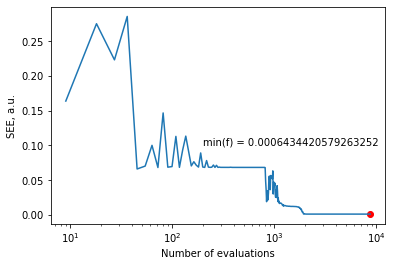

In [20]:
#plot error minimisation
fig, ax = plt.subplots()

ax.plot(evals,
        f_best)
for i in range(len(f_best)): #find where f was minimised and mark with red circle
    if f_best[i] == res[1]:
        ax.scatter(evals[i],
                   f_best[i],
                   marker = 'o',
                   color = 'red')
        
        
ax.set_xlabel('Number of evaluations')
ax.set_ylabel('SEE, a.u.')
ax.set_xscale('log')
ax.text(200, .1, f'min(f) = {res[1]}')

plt.savefig(r'./figures/optim_f-mins.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [21]:
#fit experimental data with curve_fit
WT_popt, WT_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             time[1:], WT_data[1:]) #exclude origin

short_popt, short_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             time[1:], short_data[1:]) #exclude origin

#create array with curve_fit data
x = np.linspace(0,60,600)

WT_pred = np.zeros(len(x))
short_pred = np.zeros(len(x))

for i in range(1, len(x)):
    WT_pred[i] = WT_popt[0] * np.log(x[i]) + WT_popt[1]
    short_pred[i] =  short_popt[0] * np.log(x[i]) + short_popt[1]

In [22]:
#find model data at set experimental timepoints
wt2, short2, ts2 = frac_diced(res[0])
wt_scatter2 = np.interp(time, ts2, wt2)
short_scatter2 = np.interp(time, ts2, short2)

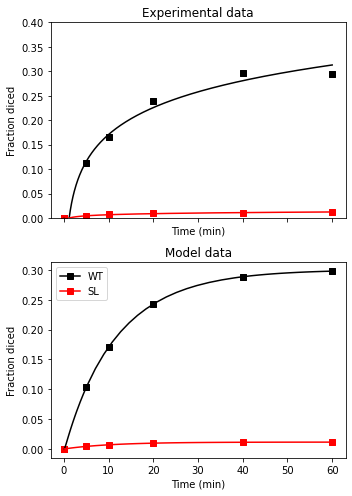

In [25]:
#plot experimental data with curve_fit, model data
fig, ax = plt.subplots(2, sharex = True, figsize = (5, 7))

ax[0].set_ylim(0, 0.4)

ax[0].plot(x,
           WT_pred,
           color = 'black')
ax[0].plot(x,
           short_pred,
           color = 'red')
ax[0].scatter(time,
              WT_data,
              marker = 's',
              color = 'black')
ax[0].scatter(time,
              short_data,
              marker = 's',
              color = 'red')

ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Fraction diced')
ax[0].set_title('Experimental data')

ax[1].plot(ts2,
           wt2,
           color = 'black')
ax[1].plot(ts2,
           short2,
           color = 'red')
ax[1].scatter(time,
              wt_scatter2,
              marker = 's',
              color = 'black')
ax[1].scatter(time,
              short_scatter2,
              marker = 's',
              color = 'red')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Fraction diced')
ax[1].set_title('Model data')

l1 = mlines.Line2D([], [], marker = 's', color = 'black', label = 'WT')
l2 = mlines.Line2D([], [], marker = 's', color = 'red', label = 'SL')

plt.legend(handles = [l1, l2], loc = 2)

plt.tight_layout()

plt.savefig(r'./figures/exp-mod-data-fit.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

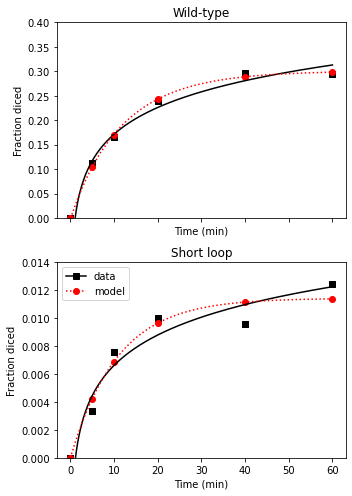

In [26]:
#plot overlaid data
fig, ax = plt.subplots(2, sharex = True, figsize = (5, 7))

ax[0].set_ylim(0, 0.4)

ax[0].plot(x,
           WT_pred,
           color = 'black')
ax[0].plot(ts2,
           wt2,
           linestyle = ':',
           color = 'red')
ax[0].scatter(time,
              WT_data,
              marker = 's',
              color = 'black')
ax[0].scatter(time,
              wt_scatter2,
              marker = 'o',
              color = 'red')

ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Fraction diced')
ax[0].set_title('Wild-type')

ax[1].set_ylim(0, 0.014)

ax[1].plot(x,
           short_pred,
           color = 'black')
ax[1].plot(ts2,
           short2,
           linestyle = ':',
           color = 'red')
ax[1].scatter(time,
              short_data,
              marker = 's',
              color = 'black')
ax[1].scatter(time,
              short_scatter2,
              marker = 'o',
              color = 'red')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Fraction diced')
ax[1].set_title('Short loop')

l1 = mlines.Line2D([], [], marker = 's', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', marker = 'o', color = 'red', label = 'model')

plt.legend(handles = [l1, l2], loc = 2)

plt.tight_layout()

plt.savefig('./figures/overlay_optims.svg', dpi = 600, bbox_inches = 'tight')

plt.show()